# **Test task 2 (Borys Melnychuk)**

Задача 2: Аналіз семантики товарів
Мета: Розробити систему для визначення емоційного відтінку та
виявлення цін у текстових коментарях.

Опис:

1. У нашій базі є інформація про числові оцінки товару з текстовим
коментарем. Потрібно створити алгоритм, який буде здатен
класифікувати коментар за емоційним забарвленням на
позитивний/негативний чи нейтральний.

2. Розробити підхід, який буде знаходити числове значення ціни з
будь якого коментаря. Ціни можуть бути зазначені у місцевій валюті
або доларах США.

Очікуваний результат: Візуальна репрезентація результатів
(ноутбук .ipynb з візуалізаціями або BI-звіт) аналітики, а також код,
який зможе приймати текстовий коментар на вхід і виділяти згадку
про ціну.

In [1]:
!pip install pysentimiento

# **Table of Contents**

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Dataset description](#1)
2. [Data loading](#2)
3. [EDA](#3)
4. [Task 2.1](#4)
5. [Task 2.2](#5)

</div>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import pysentimiento # import installed library
from pysentimiento import create_analyzer # call sentiment analyser function

2024-07-16 17:07:13.580702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 17:07:13.580825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 17:07:13.718866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Dataset description** <a id='1'></a>

Files:

* **customers.csv** - The file contains info about customers
* **orders.csv** - The file contains info about orders
* **geolocation.csv** - The file contains info about geolocations
* **order_items.csv** - The file contains info about order items
* **order_payments.csv** - The file contains info about order payments
* **order_reviews.csv** - The file contains info about order reviews
* **products.csv** - The file contains info about products
* **product_category_name_translation.csv** - The file contains info about translations of category name from portugues to english
* **sellers.csv** - The file contains info about sellers
* **dicts/** - the folder that contains **csv** files with additional data about the dataset (I used this info to create tables representing each file)

**customers.csv**

|      Name                       |    Type          |   Description                                                         |
| ---------------------------     | ---------------- | -------------------------------------------------                     |
| customer_id                     | string           | key to the orders dataset. Each order has a unique customer_unique_id |
| customer_unique_id              | string           | unique identifier of a customer                                       |
| customer_zip_code_prefix        | string           | zip code prefix of the customer. five digits of customer zip code     |
| customer_city                   | string           | customer city name                                                    |
| customer_state                  | string           | customer state                                                        | 

**orders.csv**

|      Name                     |    Type             |   Description                                                 |
| ---------------------------   | ----------------    | -------------------------------------------------             |
| order_id                      | string              | unique identifier of the order                                |
| customer_id                   | string              | key to customer dataset. each order has a unique customer_id  |
| order_status                  | string              | reference to the order status (delivered, shipped, etc).                                           |
| order_purchase_timestamp      | YYYY-MM-DD HH-MM-SS | shows the purchase timestamp                                    |
| order_approved_at             | YYYY-MM-DD HH-MM-SS | shows the payment approval timestamp                             |
| order_delivered_carrier_date  | YYYY-MM-DD HH-MM-SS | shows the order posting timestamp. when it was handled to the logistic partner | 
| delivered_customer_date       | YYYY-MM-DD HH-MM-SS | shows the actual order delivery date to the customer                        | 
| order_estimated_delivery_date | YYYY-MM-DD HH-MM-SS | shows the estimated delivery date that was informed to the customer at the purchase time | 

**geolocation.csv**

|      Name                     |    Type            |   Description               |
| ---------------------------   | ----------------   | --------------------------- |
| geolocation_zip_code_prefix   | string             | first 5 digits of zip code  |
| geolocation_lat               | float              | latitude                    |
| geolocation_lng               | float              | longitude                   |
| geolocation_city              | string             | city name                   |
| geolocation_state             | string             | state name                  |

**order_items.csv**

|      Name           |    Type             |   Description                       |
| -----------------   | ----------------    | ---------------------------         |
| order_id            | string              | order unique identifier                     |
| order_item_id       | int                 | sequential number identifying number of items included in the same order |
| product_id          | string              | product unique identifier                   |
| seller_id           | string              | seller unique identifier     |
| shipping_limit_date | YYYY-MM-DD HH-MM-SS | shows the seller shipping limit date for handling the order over to the logistic partner. |
| price               | float               | item price                           |
| freight_value       | float               | item freight value item (if an order has more than one item the freight value is splitted between items) |

**order_payments.csv**

|      Name            |    Type             |   Description                       |
| -----------------    | ----------------    | ---------------------------         |
| order_id             | string              | unique identifier of an order                     |
| payment_sequential   | int                 | a customer may pay an order with more than one payment method. If he does so	a sequence will be created to                  |
| payment_type         | string              | method of payment chosen by the customer.	                        |
| payment_installments | int                 | number of installments chosen by the customer.	             |
| payment_value        | float               | transaction value                      |

**order_reviews.csv**

|      Name               |    Type              |   Description                       |
| -----------------       | ----------------     | ---------------------------         |
| review_id               | string               | unique review identifier                   |
| order_id                | string               | unique order identifier                     |
| review_score            | int                  | note ranging from 1 to 5 given by the customer on a satisfaction survey |
| review_comment_title    | string               | comment title from the review left by the customer in portugues         |
| review_comment_message  | string               | comment message from the review left by the customer in portugues |
| review_creation_date    | YYYY-MM-DD HH-MM-SS  | shows the date in which the satisfaction survey was sent to the customer |
| review_answer_timestamp | YYYY-MM-DD HH-MM-SS  | shows satisfaction survey answer timestamp |

**products.csv**

|      Name                  |    Type              |   Description                             |
| -----------------          | ----------------     | ---------------------------               |
| product_id                 | string               | unique product identifier                         |
| product_category_name      | string               | root category of product	in Portuguese.          |
| product_name_lenght        | int                  | number of characters extracted from the product name            |
| product_description_lenght | int                  | number of characters extracted from the product description.	             |
| product_photos_qty         | int                  | number of product published photos	 |
| product_weight_g           | int                  | product weight measured in grams       |
| product_length_cm          | int                  | product length measured in centimeters	           |
| product_height_cm          | int                  | product height measured in centimeters	           |
| product_width_cm           | int                  | product width measured in centimeters	           | 

**product_category_name_translation.csv**

|      Name                     |    Type              |   Description                                  |
| -----------------             | ----------------     | ---------------------------                    |
| product_category_name         | string               | The category name of the product in portuguese |
| product_category_name_english | string               | The Category name of the product in english    |

**sellers.csv**

|      Name              |    Type              |   Description                      |
| -----------------      | ----------------     | ---------------------------        |
| seller_id              | string               | unique seller identifier                   |
| seller_zip_code_prefix | int                  | first 5 digits of seller's zip code             |
| seller_city            | string               | seller's city name    |
| seller_state           | string               | seller's state name   |

# **Data loading** <a id='2'></a>

In [3]:
# loading the datasets
order_reviews = pd.read_csv('/kaggle/input/store-data/S_Data/order_reviews.csv')
order_items = pd.read_csv('/kaggle/input/store-data/S_Data/order_items.csv')
products = pd.read_csv('/kaggle/input/store-data/S_Data/products.csv')

In [4]:
order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

# **EDA** <a id='3'></a>

Text(0.5, 1.0, 'Bar plot of review scores')

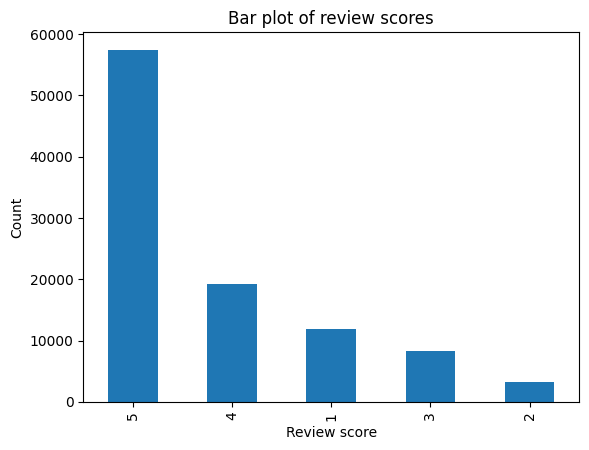

In [5]:
order_reviews['review_score'].value_counts().plot(kind='bar')
plt.xlabel('Review score')
plt.ylabel('Count')
plt.title('Bar plot of review scores')

In [6]:
print(f'Average score = {order_reviews["review_score"].mean()}')
print(f'Median score = {order_reviews["review_score"].median()}')

Average score = 4.07089
Median score = 5.0


In [7]:
# extract non null values from the reviews dataset
reviews = order_reviews[['review_id', 'order_id', 'review_score', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']].copy()
reviews.dropna(subset = ['review_comment_message'], inplace = True)

# create new column contrains review length
reviews["review_len"] = reviews.review_comment_message.str.split().apply(len) 

display(reviews.info())
print('_' * 60)
display(reviews.isnull().sum())
print('_' * 60)
reviews.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 41753 entries, 3 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                41753 non-null  object
 1   order_id                 41753 non-null  object
 2   review_score             41753 non-null  int64 
 3   review_comment_message   41753 non-null  object
 4   review_creation_date     41753 non-null  object
 5   review_answer_timestamp  41753 non-null  object
 6   review_len               41753 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.5+ MB


None

____________________________________________________________


review_id                  0
order_id                   0
review_score               0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
review_len                 0
dtype: int64

____________________________________________________________


,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,review_len
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,6
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,15
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,30
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,7
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,9
16,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2018-01-18 00:00:00,2018-01-20 21:25:45,14
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,1
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25,3
24,0e0190b9db53b689b285d3f3916f8441,79832b7cb59ac6f887088ffd686e1d5e,5,obrigado pela atençao amim dispensada,2017-12-01 00:00:00,2017-12-09 22:58:58,5
27,fe3db7c069d694bab50cc43463f91608,2ca73e2ff9e3a186ad1e1ffb9b1d9c10,5,A compra foi realizada facilmente.\r\nA entreg...,2018-03-23 00:00:00,2018-04-01 00:27:51,27


Let's plot histogram of score reviews by each class

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

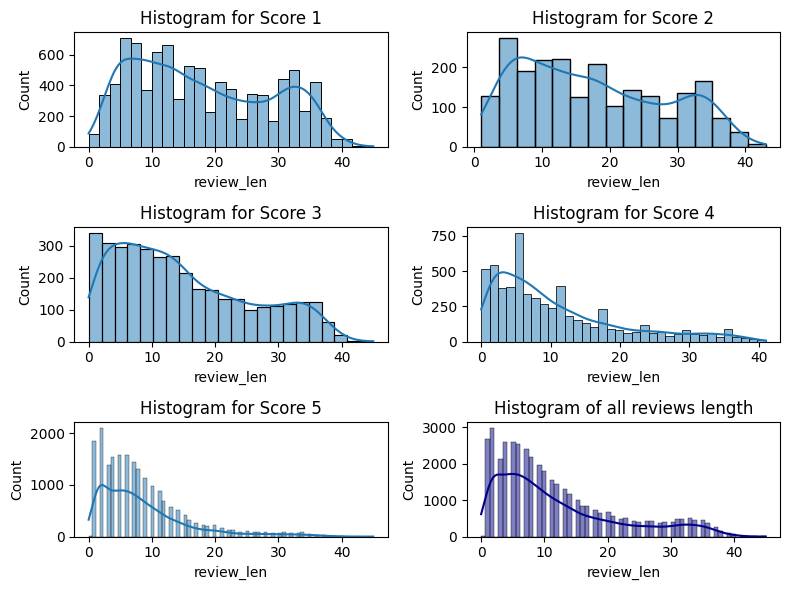

In [8]:
# create subplots for each score
fig, axs = plt.subplots(3, 2, figsize = (8, 6))

# flatten the axs array for easy iteration
axs = axs.flatten()

for score in range(1, 6):
    # Filter data for the current score
    filtered_reviews = reviews[reviews['review_score'] == score]
    # Plot histogram for the current score
    sns.histplot(data=filtered_reviews, x="review_len", ax = axs[score-1], kde = True)
    # Set title for each subplot
    axs[score - 1].set_title(f'Histogram for Score {score}')

sns.histplot(data = reviews, x = 'review_len', ax = axs[5], kde = True, color = 'darkblue')
axs[5].set_title('Histogram of all reviews length')

plt.tight_layout()
plt.show()

Build sentiment analyser function with pretained model (portuguese)

In [9]:
# preprocessing the dataset

import string

# lower all reviews and create new column
reviews['review_comments'] = reviews.review_comment_message.str.lower()

# removing ponctuation
exclude = set(string.punctuation)

def remove_ponctuation(x):
    try:
        x = ''.join(ch for ch in x if ch not in exclude)
    except:
        pass
    
    return x

# apply revomve punctuatution function lowercased column
reviews['review_comments'] = reviews.review_comments.apply(remove_ponctuation)

reviews.head(2)

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,review_len,review_comments
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,6,recebi bem antes do prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,15,parabéns lojas lannister adorei comprar pela i...


# **Task 2.1** <a id='4'></a>

In [10]:
analyzer = create_analyzer(task = "sentiment", lang = "pt") # configure the analyzer for sentiment analyses in portuguese language

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/562 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/799k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [11]:
# check first 10 rows data sentimentic reviews

for i in range(10):
    print(analyzer.predict(reviews.review_comments.iloc[i]), " output ----> ",  analyzer.predict(reviews.review_comments.iloc[i]).output, " --- rating score ----> ", reviews.review_score.iloc[i])

AnalyzerOutput(output=NEU, probas={NEU: 0.822, POS: 0.122, NEG: 0.056})  output ---->  NEU  --- rating score ---->  5
AnalyzerOutput(output=POS, probas={POS: 0.992, NEU: 0.006, NEG: 0.002})  output ---->  POS  --- rating score ---->  5
AnalyzerOutput(output=NEU, probas={NEU: 0.642, NEG: 0.287, POS: 0.071})  output ---->  NEU  --- rating score ---->  4
AnalyzerOutput(output=NEU, probas={NEU: 0.701, NEG: 0.186, POS: 0.113})  output ---->  NEU  --- rating score ---->  4
AnalyzerOutput(output=NEU, probas={NEU: 0.807, NEG: 0.105, POS: 0.089})  output ---->  NEU  --- rating score ---->  5
AnalyzerOutput(output=NEG, probas={NEG: 0.965, NEU: 0.031, POS: 0.004})  output ---->  NEG  --- rating score ---->  2
AnalyzerOutput(output=NEG, probas={NEG: 0.990, POS: 0.005, NEU: 0.005})  output ---->  NEG  --- rating score ---->  1
AnalyzerOutput(output=POS, probas={POS: 0.990, NEU: 0.008, NEG: 0.002})  output ---->  POS  --- rating score ---->  5
AnalyzerOutput(output=NEU, probas={NEU: 0.654, NEG: 0.17

In [12]:
analyzer.predict(reviews.review_comments.iloc[10]).probas

{'NEG': 0.001841648481786251,
 'NEU': 0.006744653917849064,
 'POS': 0.9914137125015259}

In [13]:
# Run the analyzer on the entire dataset

res = {}
for i, row in tqdm(reviews.iterrows(), total=len(reviews)):
    text = row['review_comments']
    myid = row['review_id']
    res[myid] = analyzer.predict(text)

  0%|          | 0/41753 [00:00<?, ?it/s]

In [14]:
# create a dataframe of the analyzer output
sentiment = pd.DataFrame(res.items(), columns=['review_id', 'analyzer_output'])

# split output results into columns
sentiment['sentiment'] = sentiment.analyzer_output.apply(lambda x: x.output)
sentiment['pos'] = sentiment.analyzer_output.apply(lambda x: x.probas['POS'])
sentiment['neu'] = sentiment.analyzer_output.apply(lambda x: x.probas['NEU'])
sentiment['neg'] = sentiment.analyzer_output.apply(lambda x: x.probas['NEG'])

# drop the analyzer output column
sentiment.drop('analyzer_output', axis = 1, inplace = True)

sentiment.head()

,review_id,sentiment,pos,neu,neg
0,e64fb393e7b32834bb789ff8bb30750e,NEU,0.122219,0.821824,0.055957
1,f7c4243c7fe1938f181bec41a392bdeb,POS,0.991741,0.006466,0.001793
2,8670d52e15e00043ae7de4c01cc2fe06,NEU,0.071043,0.642455,0.286502
3,4b49719c8a200003f700d3d986ea1a19,NEU,0.113076,0.700708,0.186216
4,3948b09f7c818e2d86c9a546758b2335,NEU,0.088626,0.806836,0.104538


In [15]:
sentiment_reviews = sentiment.merge(reviews, how = 'left', on = 'review_id')

# Now we have sentiment score and reviews
sentiment_reviews.head()

,review_id,sentiment,pos,neu,neg,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,review_len,review_comments
0,e64fb393e7b32834bb789ff8bb30750e,NEU,0.122219,0.821824,0.055957,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,6,recebi bem antes do prazo estipulado
1,f7c4243c7fe1938f181bec41a392bdeb,POS,0.991741,0.006466,0.001793,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,15,parabéns lojas lannister adorei comprar pela i...
2,8670d52e15e00043ae7de4c01cc2fe06,NEU,0.071043,0.642455,0.286502,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,30,aparelho eficiente no site a marca do aparelho...
3,4b49719c8a200003f700d3d986ea1a19,NEU,0.113076,0.700708,0.186216,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,7,mas um pouco travandopelo valor ta boa\r\n
4,3948b09f7c818e2d86c9a546758b2335,NEU,0.088626,0.806836,0.104538,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,9,vendedor confiável produto ok e entrega antes ...


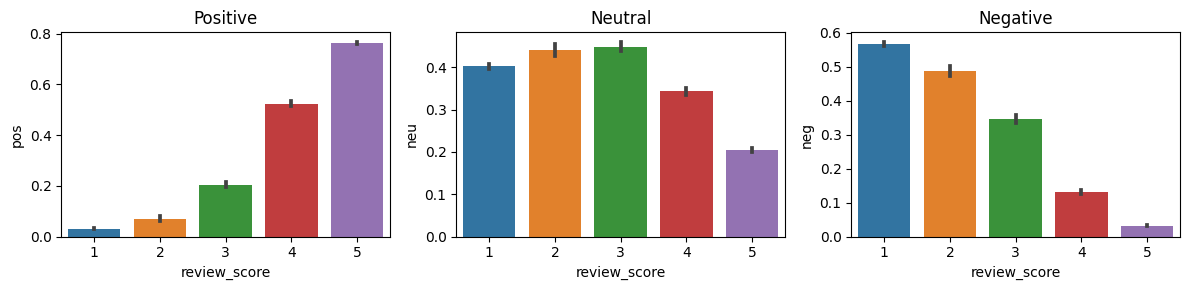

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3))
sns.barplot(data = sentiment_reviews, x = 'review_score', y = 'pos', ax = axs[0])
sns.barplot(data = sentiment_reviews, x = 'review_score', y = 'neu', ax = axs[1])
sns.barplot(data = sentiment_reviews, x = 'review_score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [17]:
def comment_sentiment(text):
    # lower text
    text = text.lower()
    
    # removing ponctuation
    text = remove_ponctuation(text)
    
    sentiment = analyzer.predict(text)
    
    output = sentiment.output
    if output == 'POS':
        output = 'positive'
    elif output == 'NEU':
        output = 'neutral'
    else:
        output = 'negative'
        
    prob = {'pos' : sentiment.probas['POS'], 'neu' : sentiment.probas['NEU'], 'neg' : sentiment.probas['NEG']}
    
    return f'Comment sentiment is {output} with these probability score {prob}'
    
    
if __name__ == '__main__':
    text = input('Enter the comment of the review: ') # esse produto é bom
    print(comment_sentiment(text))

Enter the comment of the review:  esse produto é bom


Comment sentiment is positive with these probability score {'pos': 0.9100356101989746, 'neu': 0.08621277660131454, 'neg': 0.003751620650291443}


In [18]:
# fix duplicate values in order_items dataset
data = order_items.groupby(by = ['order_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value'])['order_item_id'].max().reset_index(name = 'order_item_count')

# rearrange columns
column = ['order_id', 'order_item_count', 'product_id', 'seller_id','shipping_limit_date', 'price', 'freight_value']

# create new dataset
df_order_items = data[column]
df_order_items.head()

,order_id,order_item_count,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [19]:
# merge the order_reviews and df_order_items datasets
df_merged = pd.merge(df_order_items, order_reviews[['review_id', 'order_id', 'review_score', 'review_comment_message']], how = 'left', on = ['order_id'])

print('Shape of the merged data:     ', df_merged.shape)
# check the first 5 rows
df_merged.head()

Shape of the merged data:      (103035, 10)


,order_id,order_item_count,product_id,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_message
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,97ca439bc427b48bc1cd7177abe71365,5,"Perfeito, produto entregue antes do combinado."
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,7b07bacd811c4117b742569b04ce3580,4,NaN
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,0c5b33dea94867d1ac402749e5438e8b,5,Chegou antes do prazo previsto e o produto sur...
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,f4028d019cb58564807486a6aaf33817,4,NaN
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,940144190dcba6351888cafa43f3a3a5,5,Gostei pois veio no prazo determinado .


In [20]:
# group by dataset based product_id, count review scores

grouped_data = df_merged.groupby('product_id')

# count the occurrences of each score for each product
score_counts_per_product = grouped_data['review_score'].value_counts().unstack(fill_value = 0)

# Display the result
print(score_counts_per_product)

review_score                      1  2  3  4  5
product_id                                     
00066f42aeeb9f3007548bb9d3f33c38  0  0  0  0  1
00088930e925c41fd95ebfe695fd2655  0  0  0  1  0
0009406fd7479715e4bef61dd91f2462  1  0  0  0  0
000b8f95fcb9e0096488278317764d19  0  0  0  0  2
000d9be29b5207b54e86aa1b1ac54872  0  0  0  0  1
...                              .. .. .. .. ..
fff6177642830a9a94a0f2cba5e476d1  0  0  0  1  1
fff81cc3158d2725c0655ab9ba0f712c  0  0  0  1  0
fff9553ac224cec9d15d49f5a263411f  0  0  0  0  1
fffdb2d0ec8d6a61f0a0a0db3f25b441  0  0  0  0  5
fffe9eeff12fcbd74a2f2b007dde0c58  0  0  0  1  0

[32951 rows x 5 columns]


In [21]:
# Filter products with fewer than min_reviews_threshold reviews
score_counts_per_product = score_counts_per_product[score_counts_per_product.sum(axis=1) >= 20]

# calculate the proportion of high (5) and low (1) scores for each product
score_counts_per_product['high_score_proportion'] = (score_counts_per_product[5]) / score_counts_per_product.sum(axis=1)
score_counts_per_product['low_score_proportion'] = (score_counts_per_product[1]) / score_counts_per_product.sum(axis=1)


# sort products based on high score proportion
sorted_products = score_counts_per_product.sort_values(by = [5, 'high_score_proportion'], ascending=False)

print('Top 5 Best products')
display(sorted_products.head(5))
print()
print('_' * 80)
print('Top 5 worst products ')
display(sorted_products.tail(5)[::-1])

Top 5 Best products


review_score,1,2,3,4,5,high_score_proportion,low_score_proportion
product_id,,,,,,,
aca2eb7d00ea1a7b8ebd4e68314663af,36,17,47,102,229,0.531323,0.083424
99a4788cb24856965c36a24e339b6058,63,18,65,97,227,0.482979,0.133905
422879e10f46682990de24d770e7f83d,42,11,23,65,213,0.601695,0.118443
d1c427060a0f73f6b889a5c7c61f2ac4,34,3,20,69,197,0.609907,0.105065
389d119b48cf3043d311335e499d9c6b,32,11,23,51,194,0.623794,0.102688



________________________________________________________________________________
Top 5 worst products 


review_score,1,2,3,4,5,high_score_proportion,low_score_proportion
product_id,,,,,,,
cd46a885543f0e169a49f1eb25c04e43,22,1,1,2,2,0.071429,0.783715
c32b1155b886162db8e1ec114699a799,6,0,1,9,4,0.200000,0.297030
404a57563d487aecbc2b1a01d9b89aab,7,1,6,6,5,0.200000,0.277778
2bd9b51a9ab079e095aca987845d3266,3,1,1,11,5,0.238095,0.141256
e4ca5b20cfe1a020e15e36fe14e880ee,4,2,4,6,6,0.272727,0.179592


In [22]:
# reset the aggregated products
sorted_products.reset_index()

# merge the data with products datasets
sorted_products = sorted_products.merge(products[['product_id', 'product_category_name']], on = 'product_id')

display(sorted_products.head())

display(sorted_products.tail())

,product_id,1,2,3,4,5,high_score_proportion,low_score_proportion,product_category_name
0,aca2eb7d00ea1a7b8ebd4e68314663af,36,17,47,102,229,0.531323,0.083424,moveis_decoracao
1,99a4788cb24856965c36a24e339b6058,63,18,65,97,227,0.482979,0.133905,cama_mesa_banho
2,422879e10f46682990de24d770e7f83d,42,11,23,65,213,0.601695,0.118443,ferramentas_jardim
3,d1c427060a0f73f6b889a5c7c61f2ac4,34,3,20,69,197,0.609907,0.105065,informatica_acessorios
4,389d119b48cf3043d311335e499d9c6b,32,11,23,51,194,0.623794,0.102688,ferramentas_jardim


,product_id,1,2,3,4,5,high_score_proportion,low_score_proportion,product_category_name
618,e4ca5b20cfe1a020e15e36fe14e880ee,4,2,4,6,6,0.272727,0.179592,eletronicos
619,2bd9b51a9ab079e095aca987845d3266,3,1,1,11,5,0.238095,0.141256,consoles_games
620,404a57563d487aecbc2b1a01d9b89aab,7,1,6,6,5,0.200000,0.277778,cama_mesa_banho
621,c32b1155b886162db8e1ec114699a799,6,0,1,9,4,0.200000,0.297030,cama_mesa_banho
622,cd46a885543f0e169a49f1eb25c04e43,22,1,1,2,2,0.071429,0.783715,informatica_acessorios


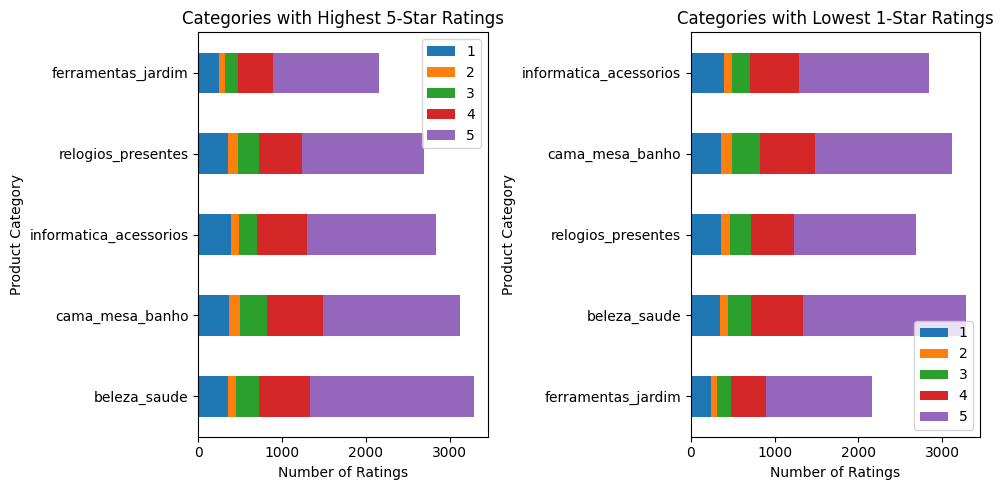

In [23]:
# Group the dataset by product category name
grouped_categories = sorted_products.groupby('product_category_name')[[1, 2, 3, 4, 5]].sum()

# sort categories based on 5-star ratings in descending order
highest_5_star_categories = grouped_categories.sort_values(by=5, ascending=False).head(5)

# sort categories based on 1-star ratings in descending order
lowest_1_star_categories = grouped_categories.sort_values(by = 1, ascending = False).head(5)[::-1]

# create subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot highest 5-star categories
highest_5_star_categories.plot(kind='barh', stacked=True, ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[0].set_title('Categories with Highest 5-Star Ratings')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Product Category')

# plot lowest 1-star categories
lowest_1_star_categories.plot(kind='barh', stacked=True, ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1].set_title('Categories with Lowest 1-Star Ratings')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Product Category')

plt.tight_layout()
plt.show()

In [24]:
# group by dataset based seller, count review scores

grouped_data_seller = df_merged.groupby('seller_id')

# count the occurrences of each score for each seller
seller_scores = grouped_data_seller['review_score'].value_counts().unstack(fill_value = 0).reset_index()

# rename columns
seller_scores.rename(columns = {1: 'score_1', 2: 'score_2', 3: 'score_3', 4:'score_4', 5: 'score_5'}, inplace = True)

# display the result
seller_scores.head()

review_score,seller_id,score_1,score_2,score_3,score_4,score_5
0,0015a82c2db000af6aaaf3ae2ecb0532,1,0,0,0,2
1,001cca7ae9ae17fb1caed9dfb1094831,27,8,20,42,104
2,001e6ad469a905060d959994f1b41e4f,1,0,0,0,0
3,002100f778ceb8431b7a1020ff7ab48f,7,1,9,8,31
4,003554e2dce176b5555353e4f3555ac8,0,0,0,0,1


In [25]:
# find a seller who has only negative (score 1) 

seller_scores[(seller_scores.score_2 == 0) & (seller_scores.score_3 == 0) &  (seller_scores.score_4 == 0) & (seller_scores.score_5 == 0)].sort_values(by = 'score_1', ascending = False)

review_score,seller_id,score_1,score_2,score_3,score_4,score_5
3045,fc6295add6f51a0936407ead70c1001d,4,0,0,0,0
425,244b04680fdbded0acf5aebd9c92b44a,3,0,0,0,0
940,4e42581f08e8cfc7c090f930bac4552a,3,0,0,0,0
2997,f7df46c1e0ec44eed5c6726478da4a17,3,0,0,0,0
1777,90d4125885ab6c86e8820a722be71974,3,0,0,0,0
...,...,...,...,...,...,...
1247,6614814a00d344b846ae209f95ee7e3f,1,0,0,0,0
1255,66d5ae34537110d3affc56174dad2b2f,1,0,0,0,0
1329,6d04126aba80df143fd038e711b8fd96,1,0,0,0,0
1345,6e2d3e2dc84fb30f6078f39dd3bddd6f,1,0,0,0,0


# **Task 2.2** <a id='5'></a>

In [26]:
import re

# create a function extract digits related to currency
def extract_currency(text):
    # define regex pattern to match currency values
    pattern = r'\b\d+(?:\.\d+)?(?:\$|USD|US\$|dollars?|euros?|pounds?|yen|yuan|rupees?|pesos?|cents?|pence|€|£|¥|₹|₱)?\b'
    
    # find all matches of currency values in the text
    matches = re.findall(pattern, text)
    
    # return the extracted currency values
    if len(matches) != 0:
        return matches
    else:
        return 0

tqdm.pandas(desc = 'My bar!') # lots of cool paramiters you can pass here. 

sentiment_reviews['price_in_text'] = sentiment_reviews.review_comment_message.apply(extract_currency)

# get the rows that price_in_text is not 0
sentiment_reviews[sentiment_reviews.price_in_text != 0]

,review_id,sentiment,pos,neu,neg,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,review_len,review_comments,price_in_text
7,d21bbc789670eab777d27372ab9094cc,POS,0.989803,0.007803,0.002393,4fc44d78867142c627497b60a7e0228a,5,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25,3,loja nota 10,[10]
22,e233e51d11511bf30e568c76360ace52,NEU,0.019901,0.612586,0.367513,548df2c6e5f089574614894bca78acf5,1,recebi somente 1 controle Midea Split ESTILO.\...,2018-01-28 00:00:00,2018-02-04 11:06:15,14,recebi somente 1 controle midea split estilo\r...,[1]
45,ae728c1061bf163b4bd256ad9ee0bb83,NEU,0.029350,0.922403,0.048248,45c780334bc32cb77559a65c5f171160,1,Este foi o pedido\r\nBalde Com 128 Peças - Blo...,2018-01-04 00:00:00,2018-01-10 09:52:57,41,este foi o pedido\r\nbalde com 128 peças bloc...,"[128, 2, 25, 00, 36, 1, 35, 90]"
68,d7ea05bb4f9c77d606fd90b1a27e317d,NEG,0.010191,0.020473,0.969336,bb5b0d8f3e9c964760c674f2aa2ae0cf,1,Comprei o produto dia 25 de fevereiro e hoje d...,2018-03-29 00:00:00,2018-03-29 23:13:58,36,comprei o produto dia 25 de fevereiro e hoje d...,"[25, 29]"
69,185cb85ede91009d7a8e685687c037ee,NEG,0.017061,0.054756,0.928182,2e5dc86c8c4aa663549caf5e31de840d,1,fiz minha compra faz 30 dias e não recebi aind...,2017-04-06 00:00:00,2017-04-09 18:25:12,16,fiz minha compra faz 30 dias e não recebi aind...,[30]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41693,970ae7c9df61910a0a30c38670db7ae5,NEG,0.023498,0.431535,0.544966,b7e332393b5e64cdc10d308c971a41c4,3,Teve um probleminha minha pasta multiuso pra n...,2018-08-28 00:00:00,2018-08-30 16:53:31,26,teve um probleminha minha pasta multiuso pra n...,[15.6]
41723,9ed2a6bc2282fd2b0105055631afa57f,NEG,0.005479,0.010348,0.984173,a7db1b7bfec5e83a8fd33625e99f0d15,1,Ate hoje dia 21/10/2017 o pedido não foi entre...,2017-10-21 00:00:00,2017-10-21 18:51:37,35,ate hoje dia 21102017 o pedido não foi entregu...,"[21, 10, 2017]"
41730,2fc8295a24978092328d3a329d22940e,NEU,0.058375,0.845394,0.096231,e809c167a9cfd31aee1293abe8995065,1,Eu recebi o seguinte email e preciso saber com...,2018-02-09 00:00:00,2018-02-13 13:03:24,37,eu recebi o seguinte email e preciso saber com...,"[04, 2018]"
41743,51de4e06a6b701cb2be47ea0e689437b,NEU,0.032570,0.923517,0.043913,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19,14,bom dia \r\ndas 6 unidades compradas só recebi...,"[6, 4]"
